# Machine Learning Functions for Streamlit App

In [1]:
# Environments
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from datetime import datetime
from pvlive_api import PVLive
import time
from datetime import datetime, timedelta, timezone
import requests_cache
from retry_requests import retry
import openmeteo_requests

In [2]:
# Initiating PVLive API as per GIT repo instructions: https://github.com/SheffieldSolar/PV_Live-API
pvl = PVLive(
    retries=3, # Optionally set the number of retries when intermittent issues are encountered
    proxies=None, # Optionally pass a dict of proxies to use when making requests
    ssl_verify=True, # Optionally disable SSL certificate verification (not advised!)
    domain_url="api.pvlive.uk", # Optionally switch between the prod and FOF APIs
)

In [3]:
# Set GSP and timeframes to call functions
start = datetime(2025, 1, 1, 0, 0, tzinfo=pytz.UTC)
end = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)
gsp_id = 124  # select GSP ID to extract data for - later we will ue table of names for this

In [4]:
def load_mwp(region="gsp", include_history=True):
    """
    Load and return the MWp deployment dataframe as mwp_df via pvl.deployment.
    """
    mwp_df = pvl.deployment(region=region, include_history=include_history)
    return mwp_df

def load_gsp(gsp_path="../data/gsp_info.csv"):
    """
    Load and return the GSP info dataframe as gsp_df from CSV,
    filtered to only GSPs known to PVLive (pvl.gsp_ids).
    """
    pvl = PVLive()
    valid_ids = set(pvl.gsp_ids)

    gsp_df = pd.read_csv(gsp_path)

    if 'gsp_id' in gsp_df.columns:
        # coerce non-numeric to NaN, drop those rows, cast to int, then filter by PVLive ids
        gsp_df['gsp_id_num'] = pd.to_numeric(gsp_df['gsp_id'], errors='coerce')
        gsp_df = gsp_df[gsp_df['gsp_id_num'].notna()].copy()
        gsp_df['gsp_id_num'] = gsp_df['gsp_id_num'].astype(int)
        gsp_df = gsp_df[gsp_df['gsp_id_num'].isin(valid_ids)].drop(columns=['gsp_id_num']).reset_index(drop=True)

    return gsp_df

def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    Remove the 'unkown' rows from the mwp_df - presumably misspelling of unknown.
    Drop any rows with missing values.
    
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].drop_duplicates('_gsp_key')    
    merged = mwp.merge(to_merge, on='_gsp_key', how='left') # Left merge so all mwp rows are kept
    merged = merged.dropna(how='any')   # drop all rows where ther are NaN values - return only the 299 intersection GSPs
    merged = merged[merged[gsp_col_mwp] != 'unkown']  # return the df where not equal to unkown
    merged = merged.drop(columns=['_gsp_key'])  # Drop linking key

    return merged
    
def gsp_locations(merged_df, gsp_col='GSPs'):
    """
    Return a DataFrame with one row per unique GSP containing
    gsp_col, gsp_lat, gsp_lon, region_name, pes_id, and a combined
    'GSP_region' column formatted "GSPs | region_name".
    """
    gsp_locations_list = (
        merged_df
        .drop_duplicates(subset=[gsp_col])[[gsp_col, 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]
        .reset_index(drop=True)
    )
    gsp_locations_list['GSP_region'] = gsp_locations_list[gsp_col].astype(str) + ' | ' + gsp_locations_list['region_name'].astype(str)
    return gsp_locations_list

def wide_cumul_capacity(merged_df, time_col='install_month', gsp_col='GSPs', value_col='cumul_capacity_mwp'):
    """
    Return a DataFrame with:
    - one column for the time (time_col) monthly intervals
    - one column per GSP (column name = GSP identifier)
    - cells = value_col (cumulative capacity MWP)
    """
    import pandas as pd
    df = merged_df.copy()
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass
    wide = df.pivot_table(index=time_col, columns=gsp_col, values=value_col, aggfunc='first')
    wide = wide.reset_index()  # make time a regular column
    return wide

def download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list, include_national=False, extra_fields=""):
    """
    Return a DataFrame with:
    - generation data for selected period for one GSP
    - one column for the time (time_col) HH intervals
    - other columns for GSP identifiers
    """
    valid_ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()  # Get the valid gsp_ids from gsp_locations_list
    if gsp_id not in valid_ids:  # Check if the provided gsp_id is valid
        return f"Please select a GSP ID which appears in the GSP capacity list."

    # Fetch data for the specific GSP ID using between function from PVLive API Class
    generation_df = pvl.between(
        start=start,
        end=end,
        entity_type="gsp",
        entity_id=int(gsp_id),
        dataframe=True,
        extra_fields=extra_fields
    )

    # Interpolate up to 24 consecutive NaN values in the generation output - 12 in either direction  
    if generation_df is not None and not generation_df.empty:
        generation_df['datetime_gmt'] = pd.to_datetime(generation_df['datetime_gmt'])
        generation_df = generation_df.sort_values(['gsp_id', 'datetime_gmt']).set_index('datetime_gmt')
        generation_df['generation_mw'] = (
            generation_df.groupby('gsp_id')['generation_mw']
            .apply(lambda s: s.interpolate(method='time', limit=12, limit_direction='both'))
            .reset_index(level=0, drop=True)
        )
        generation_df = generation_df.reset_index()
        
    # Merge additional columns from gsp_locations_list
    gsp_info = gsp_locations_list[gsp_locations_list['gsp_id'] == gsp_id]
    if not gsp_info.empty:
        # Merge on gsp_id to include other columns like gsp_lat, gsp_lon, etc.
        generation_df = generation_df.merge(gsp_info, on='gsp_id', how='left')
        
    return generation_df

def get_capacity_data_single_gsp(gsp_id, merged_df):
    """
    Return a DataFrame containing capacity data for the specified GSP ID,
    along with month and year columns based on the install_month
    
    """
    # Filter the DataFrame for the specified GSP ID and add time-series columns for mathing with generation df
    capacity_data = merged_df[merged_df['gsp_id'] == gsp_id].copy()
    capacity_data = capacity_data[['install_month', 'cumul_capacity_mwp', 'GSPs', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]   # Keep relevant columns
    capacity_data['install_month'] = pd.to_datetime(capacity_data['install_month'])    # Convert install_month to datetime
    capacity_data['month'] = capacity_data['install_month'].dt.month     # Create 'month' and 'year' columns
    capacity_data['year'] = capacity_data['install_month'].dt.year
    capacity_data['day'] = capacity_data['install_month'].dt.day
    capacity_data['hour'] = capacity_data['install_month'].dt.hour
    return capacity_data.reset_index(drop=True)

def add_capacity_to_generation(generation_df, capacity_data, tz='UTC', gen_fill_method='interpolate'):
    """
    Merge cumulative capacity into generation_df, then reindex to a full 30-minute UTC grid
    and interpolate missing generation_mw and capacity_mwp values. Returns DataFrame indexed by datetime_gmt (tz-aware).
    
    Parameters:
    - generation_df: DataFrame with 'datetime_gmt' and 'generation_mw'
    - capacity_data: DataFrame with ['month', 'year', 'cumul_capacity_mwp']
    - tz: timezone for indexing (default 'UTC')
    - gen_fill_method: 'interpolate' (default) or 'zero' to fill generation gaps
    """
    # Ensure datetime and timezone
    generation_df = generation_df.copy()
    generation_df['datetime_gmt'] = pd.to_datetime(generation_df['datetime_gmt'])
    if generation_df['datetime_gmt'].dt.tz is None:
        generation_df['datetime_gmt'] = generation_df['datetime_gmt'].dt.tz_localize(tz)
    else:
        generation_df['datetime_gmt'] = generation_df['datetime_gmt'].dt.tz_convert(tz)

    # Add time components
    generation_df['month'] = generation_df['datetime_gmt'].dt.month
    generation_df['year'] = generation_df['datetime_gmt'].dt.year
    generation_df['day'] = generation_df['datetime_gmt'].dt.day
    generation_df['hour'] = generation_df['datetime_gmt'].dt.hour

    # Merge capacity (by month/year) and forward-fill capacity
    merged_df = generation_df.merge(
        capacity_data[['month', 'year', 'cumul_capacity_mwp']],
        on=['month', 'year'],
        how='left'
    ).rename(columns={'cumul_capacity_mwp': 'capacity_mwp'})
    merged_df['capacity_mwp'] = merged_df['capacity_mwp'].ffill()

    # Set datetime index and select relevant columns, including ffill on specific fields
    merged_df = merged_df.set_index('datetime_gmt').sort_index()

    # Build full 30-minute index from min to max
    full_idx = pd.date_range(merged_df.index.min(), merged_df.index.max(), freq='30min', tz=tz)

    # Reindex to full grid
    merged_df = merged_df.reindex(full_idx)

    # Fill remaining NaNs for generation_mw
    if 'generation_mw' in merged_df.columns:
        if gen_fill_method == 'interpolate':
            merged_df['generation_mw'] = merged_df['generation_mw'].interpolate(limit_direction='both')
        else:
            merged_df['generation_mw'] = merged_df['generation_mw'].fillna(0)
    
    # Fill remaining NaNs for capacity_mw
    if 'capacity_mwp' in merged_df.columns:
        if gen_fill_method == 'interpolate':
            merged_df['capacity_mwp'] = merged_df['capacity_mwp'].interpolate(limit_direction='both')
        else:
            merged_df['capacity_mwp'] = merged_df['capacity_mwp'].fillna(0)
        
    # Forward fill for newly made specific non-numeric columns
    ffill_columns = ['gsp_id', 'GSPs', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id', 'GSP_region']
    for col in ffill_columns:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].ffill()

    # Recompute time component columns from index for any newly created rows
    merged_df['month'] = merged_df.index.month
    merged_df['year'] = merged_df.index.year
    merged_df['day'] = merged_df.index.day
    merged_df['hour'] = merged_df.index.hour

    # Reset index name to 'datetime_gmt'
    merged_df.index.name = 'datetime_gmt'

    return merged_df.reset_index()

def fetch_weather_for_generation_df(gen_df,
                                    cache_path=".cache",
                                    cache_expire=3600,
                                    retries=5,
                                    backoff_factor=0.2):
    """
    Extract lat/lon and date range from generation_and_capacity_single_gsp-like
    DataFrame (expects 'gsp_lat', 'gsp_lon', 'datetime_gmt'), call Open-Meteo via
    openmeteo_requests and return hourly weather DataFrame indexed by UTC datetime
    with added columns: year, month, day, hour.
    """
    # Extract lat/lon from first non-null row
    row = gen_df[['gsp_lat', 'gsp_lon']].dropna().iloc[0]
    latitude, longitude = float(row['gsp_lat']), float(row['gsp_lon'])

    # Derive start/end dates (YYYY-MM-DD)
    start_date = gen_df['datetime_gmt'].min().normalize().strftime('%Y-%m-%d')
    end_date = gen_df['datetime_gmt'].max().normalize().strftime('%Y-%m-%d')

    # Setup client with cache + retry
    cache_session = requests_cache.CachedSession(cache_path, expire_after=cache_expire)
    retry_session = retry(cache_session, retries=retries, backoff_factor=backoff_factor)
    client = openmeteo_requests.Client(session=retry_session)
    if not hasattr(client, "_close_session"):
        client._close_session = False  # avoid destructor AttributeError

    hourly_vars = [
        "shortwave_radiation", "direct_radiation", "diffuse_radiation",
        "direct_normal_irradiance", "global_tilted_irradiance",
        "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant",
        "direct_normal_irradiance_instant", "global_tilted_irradiance_instant",
    ]

    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": hourly_vars,
    }

    responses = client.weather_api(url, params=params)
    if not responses:
        return pd.DataFrame()

    response = responses[0]
    hourly = response.Hourly()
    hourly_arrays = [hourly.Variables(i).ValuesAsNumpy() for i in range(len(hourly_vars))]

    start_ts = pd.to_datetime(hourly.Time(), unit="s", utc=True)
    end_ts = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True)
    interval_seconds = int(hourly.Interval())
    dates = pd.date_range(
        start=start_ts,
        end=end_ts,
        freq=pd.Timedelta(seconds=interval_seconds),
        inclusive="left"
    )

    data = {"date": dates}
    for name, arr in zip(hourly_vars, hourly_arrays):
        data[name] = arr[: len(dates)]

    df = pd.DataFrame(data).set_index("date")

    # Add year, month, day, hour columns from the index
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour

    return df

def merge_generation_with_weather(generation_df, weather_df):
    """
    Merge generation_and_capacity_single_gsp dataframe with weather_df.
    Only brings generation_mw and capacity_mwp from generation_df.
    - generation_df: must contain ['year','month','day','hour','generation_mw','capacity_mwp']
      (two half-hour rows per hour; this function averages per hour).
    - weather_df: indexed by UTC datetime and must contain columns ['year','month','day','hour']
    Returns: DataFrame with weather_df index and merged averaged columns:
             generation_mw, capacity_mwp (aligned to weather hourly rows).
    """
    # Select only required columns
    cols = ['year', 'month', 'day', 'hour', 'generation_mw', 'capacity_mwp']
    gen = generation_and_capacity_single_gsp[cols].copy()
    grouped = gen.groupby(['year', 'month', 'day', 'hour'], as_index=False)[['generation_mw', 'capacity_mwp']].mean() # Aggregate to hourly by mean
    weather = weather_df.copy().reset_index()  # bring datetime index to column named 'date'
    merged = weather.merge(grouped, on=['year', 'month', 'day', 'hour'], how='left') # Merge with weather_df on year,month,day,hour
    
    # Failsafe itnterpolate remaining NaN values in generation_mw and capacity_mwp
    if 'generation_mw' in merged.columns:
        merged['generation_mw'] = merged['generation_mw'].interpolate(limit_direction='both')

    if 'capacity_mwp' in merged.columns:
        merged['capacity_mwp'] = merged['capacity_mwp'].interpolate(limit_direction='both')
   
    # restore datetime index
    merged = merged.set_index('date')

    return merged


In [5]:
# Call functions and create variables with dataframes for use in the app
mwp_df = load_mwp() # loading the capacity df
gsp_df = load_gsp() # loading the gsp locations df
merged_df = merge_gsp_location(mwp_df, gsp_df) # merge capacity growth and locations
gsp_locations_list = gsp_locations(merged_df) # merge capacity and locations without capacity growth over time
generation_df = download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list) # generation df for selected gsp
capacity_growth_all_gsps = wide_cumul_capacity(merged_df) # wide capacity growth df for all time and all gsps
capacity_data_single_gsp = get_capacity_data_single_gsp(gsp_id, merged_df) # add month and year to capacity single gsp
generation_and_capacity_single_gsp = add_capacity_to_generation(generation_df, capacity_data_single_gsp) # merged capacity and generation same time-series single gsp
weather_df = fetch_weather_for_generation_df(generation_and_capacity_single_gsp) # weather df for the selected gsp and time period
gen_weather_merged_df = merge_generation_with_weather(generation_and_capacity_single_gsp, weather_df)
gen_weather_merged_df

,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,year,month,day,hour,generation_mw,capacity_mwp
date,,,,,,,,,,,,,,,,
2025-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,0,0.0,7.358246
2025-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,1,0.0,7.358246
2025-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,2,0.0,7.358246
2025-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,3,0.0,7.358246
2025-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,4,0.0,7.358246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,12,31,19,0.0,8.076596
2025-12-31 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,12,31,20,0.0,8.076596
2025-12-31 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,12,31,21,0.0,8.076596


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_test,y_train, y_test = train_test_split(
                                    gen_weather_merged_df.drop(['generation_mw'],axis=1),
                                    gen_weather_merged_df['generation_mw'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (7008, 15) (7008,) 
* Test set: (1752, 15) (1752,)


In [13]:
def pipeline_xgboost_reg():
    pipeline = Pipeline([
        ("feat_selection", SelectFromModel(XGBRegressor(random_state=42, n_estimators=50, n_jobs=-1, verbosity=0))),
        ("model", XGBRegressor(
            random_state=42,
            n_estimators=50,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=1.0,
            n_jobs=-1,
            verbosity=0
        )),
    ])
    return pipeline

pipeline_xgboost_reg()

pipeline = pipeline_xgboost_reg()
pipeline.fit(X_train, y_train)

,steps,"[('feat_selection', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,estimator,"XGBRegressor(...ree=None, ...)"
,threshold,None
,prefit,False
,norm_order,1
,max_features,None
,importance_getter,'auto'
,objective,'reg:squarederror'


In [15]:
def prepare_and_fit_xgboost(df, target_col='generation_mw', test_size=0.2, random_state=101):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop([target_col], axis=1),
        df[target_col],
        test_size=test_size,
        random_state=random_state
    )

    # Define the XGBoost pipeline
    pipeline = Pipeline([
        ("feat_selection", SelectFromModel(XGBRegressor(random_state=42, n_estimators=50, n_jobs=-1, verbosity=0))),
        ("model", XGBRegressor(
            random_state=42,
            n_estimators=50,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=1.0,
            n_jobs=-1,
            verbosity=0
        )),
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)
    
    return pipeline, X_train, X_test, y_train, y_test

# Usage
pipeline, X_train, X_test, y_train, y_test = prepare_and_fit_xgboost(gen_weather_merged_df)


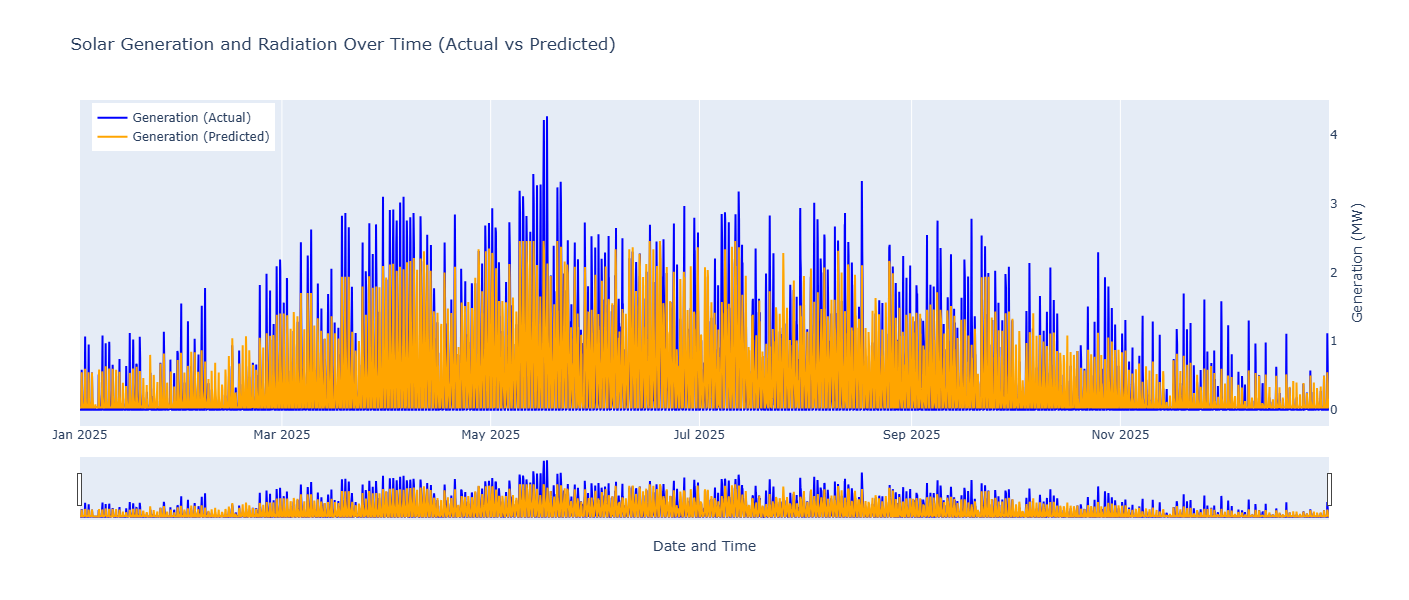

In [16]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Assume: pipeline is fitted, X_train/X_test are the feature DataFrames used for training/testing,
# and gen_weather_merged_df contains the 'generation_mw' actuals with a datetime index.

# Combine X_train and X_test to predict for the whole dataset you're evaluating
X_full = pd.concat([X_train, X_test]).sort_index()
y_index = X_full.index

# Get predictions from the fitted pipeline (preserves order of X_full)
y_pred_full = pipeline.predict(X_full)

# Prepare a copy of the original df for plotting (avoid mutation)
df_plot = gen_weather_merged_df.copy()
df_plot['datetime_gmt'] = pd.to_datetime(df_plot.index)

# Create a column aligned to the feature index with predictions (NaN elsewhere)
df_plot['pred_generation_mw'] = np.nan
df_plot.loc[y_index, 'pred_generation_mw'] = y_pred_full

# Create Plotly figure with the same radiation traces plus actual and predicted generation
fig = go.Figure()

# Actual generation on secondary y-axis
fig.add_trace(go.Scatter(
    x=df_plot['datetime_gmt'],
    y=df_plot['generation_mw'],
    mode='lines',
    name='Generation (Actual)',
    line=dict(color='blue'),
    yaxis='y2'
))

# Predicted generation on secondary y-axis (use dashed line or different color)
fig.add_trace(go.Scatter(
    x=df_plot['datetime_gmt'],
    y=df_plot['pred_generation_mw'],
    mode='lines',
    name='Generation (Predicted)',
    line=dict(color='orange'),
    yaxis='y2'
))

# Layout with secondary y-axis
fig.update_layout(
    title='Solar Generation and Radiation Over Time (Actual vs Predicted)',
    xaxis_title='Date and Time',
    yaxis_title='Radiation Values',
    yaxis2=dict(
        title='Generation (MW)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    xaxis=dict(rangeslider=dict(visible=True)),
    legend=dict(x=0.01, y=0.99),
    height=600
)

fig.show()
